# Clustering: Clustering de Lineas mediante KMeans y Jerárquico

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import matplotlib.dates as mdates

from pyspark import SparkContext, SQLContext
from pyspark.ml.feature import VectorAssembler

from pyspark.sql import SQLContext
from pyspark.sql.types import *


sqlCtx = SQLContext(sc)

/opt/cloudera/parcels/Anaconda-4.0.0/envs/pyspark/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## 1. Carga de Datos

In [2]:
#Carga de los datos para los dias Laborables
df_lineas_laborables=sqlContext.sql("select fecha,linea,sum(n_viajeros) as n_viajeros from emt_smartbus.viajeros_tramos_master_nooutliers where festivo=0 and \
                                  (dia_semana='L' or dia_semana='M' or dia_semana='X' or dia_semana='J' or dia_semana='V') group by fecha,linea ORDER BY fecha")

#Carga de los datos para los dias Festivos
df_lineas_festivos=sqlContext.sql("select fecha,linea,sum(n_viajeros) as n_viajeros from emt_smartbus.viajeros_tramos_master_nooutliers where \
                                  (dia_semana='S' or dia_semana='D' or festivo=1) group by fecha,linea ORDER BY fecha")


In [3]:
df_lineas_laborables.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150102|  402|      4648|
|20150102|  152|      5630|
|20150102|  517|       589|
|20150102|   79|      2688|
|20150102|  507|       428|
|20150102|  510|       643|
|20150102|  457|       112|
|20150102|   55|      7478|
|20150102|   24|      5988|
|20150102|  172|      2370|
|20150102|   65|      5525|
|20150102|   67|      4727|
|20150102|   36|      4920|
|20150102|   27|     24055|
|20150102|  162|      2170|
|20150102|   76|      2152|
|20150102|  509|       655|
|20150102|  114|      2594|
|20150102|  523|       702|
|20150102|   47|      6744|
+--------+-----+----------+
only showing top 20 rows



In [4]:
df_lineas_festivos.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150101|  138|      1955|
|20150101|   75|      1326|
|20150101|  511|       376|
|20150101|   66|      2339|
|20150101|   16|       925|
|20150101|  139|       614|
|20150101|  111|      1187|
|20150101|   73|       886|
|20150101|  116|      1138|
|20150101|  402|       835|
|20150101|  128|      2417|
|20150101|  127|      1484|
|20150101|   24|      1730|
|20150101|  131|      1218|
|20150101|   46|      1199|
|20150101|  107|       740|
|20150101|  103|      1105|
|20150101|    9|      3157|
|20150101|   26|      1870|
|20150101|  118|      2679|
+--------+-----+----------+
only showing top 20 rows



###### Eliminamos las lineas "raras" (lineas que tienen una gran cantidad de 0s)

In [5]:
from pyspark.sql.functions import col

lineas_raras_laborables= [13,84,88,97,98,180,193,196,201,211,225,227,233,276,288,297,299,301,316,321,322,333,339,349,372,399,405,410,431,434,435,436,440,443,445,446,449,465,499,533,543,
               544,550,552,558,560,588,610,611,622,623,647,660,663,666,679,685,690,700,701,712,722,733,735,739,744,777,778,785,801,802,803,804,805,806,807,808,809,810,811,812,
               815,816,817,818,819,820,822,824,825,826,829,841,848,851,854,855,862,877,885,886]

for l in lineas_raras_laborables:
    df_lineas_laborables = df_lineas_laborables.filter((col('linea') != l))

df_lineas_laborables.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150102|  114|      2594|
|20150102|  210|      3052|
|20150102|   67|      4727|
|20150102|  523|       702|
|20150102|  514|       547|
|20150102|   69|     16214|
|20150102|   70|     15776|
|20150102|   10|     12331|
|20150102|  509|       655|
|20150102|   40|      4099|
|20150102|   76|      2152|
|20150102|   44|      7439|
|20150102|  176|      3856|
|20150102|  521|      1122|
|20150102|  502|       596|
|20150102|   93|       233|
|20150102|  130|      4189|
|20150102|  517|       589|
|20150102|  310|      1964|
|20150102|   11|      3308|
+--------+-----+----------+
only showing top 20 rows



In [6]:
lineas_raras_festivos= [13,90,190,199,204,214,217,274,277,300,334,335,337,375,377,399,440,528,551,554,
                        603,610,633,657,660,666,670,676,679,725,730,763,766,779,800,809,810,812,814,853,855,869]

for l in lineas_raras_festivos:
    df_lineas_festivos = df_lineas_festivos.filter((col('linea') != l))

df_lineas_festivos.show()

+--------+-----+----------+
|   fecha|linea|n_viajeros|
+--------+-----+----------+
|20150101|   50|      1328|
|20150101|   20|      3833|
|20150101|  516|       453|
|20150101|   11|       688|
|20150101|  126|      1372|
|20150101|  515|       448|
|20150101|   18|      1920|
|20150101|  116|      1138|
|20150101|   66|      2339|
|20150101|   47|      2448|
|20150101|  517|       539|
|20150101|  402|       835|
|20150101|  131|      1218|
|20150101|   62|      1233|
|20150101|  137|       949|
|20150101|   59|      1368|
|20150101|    3|      2635|
|20150101|  210|       754|
|20150101|  133|      2769|
|20150101|  509|       426|
+--------+-----+----------+
only showing top 20 rows



## 2. Preprocesado de Datos

### 2.1. Creación de Pivot Tables

In [7]:
#Ordenamos por fecha
df_lineas_laborables_pivot=df_lineas_laborables.orderBy(df_lineas_laborables.fecha.asc(),df_lineas_laborables.linea.asc())
df_lineas_festivos_pivot=df_lineas_festivos.orderBy(df_lineas_festivos.fecha.asc(),df_lineas_festivos.linea.asc())

In [8]:
from pyspark.sql.functions import first

# Transponer las columnas para que tengamos una columna por linea
df_lineas_laborables_pivot = df_lineas_laborables_pivot.groupBy('linea').pivot('fecha').agg(first("n_viajeros"))
df_lineas_festivos_pivot = df_lineas_festivos_pivot.groupBy('linea').pivot('fecha').agg(first("n_viajeros"))

In [9]:
# Eliminamos los Missing values
df_lineas_laborables_filter=df_lineas_laborables_pivot.na.fill(0.0)
df_lineas_festivos_filter=df_lineas_festivos_pivot.na.fill(0.0)

In [10]:
# Ordenamos por fecha
df_lineas_laborables_filter=df_lineas_laborables_filter.orderBy(df_lineas_laborables_filter.linea.asc())
df_lineas_festivos_filter=df_lineas_festivos_filter.orderBy(df_lineas_festivos_filter.linea.asc())

In [11]:
# Guardamos los dataset en cache
df_lineas_laborables_filter.cache()
df_lineas_festivos_filter.cache()

DataFrame[linea: int, 20150101: bigint, 20150103: bigint, 20150104: bigint, 20150106: bigint, 20150110: bigint, 20150111: bigint, 20150117: bigint, 20150118: bigint, 20150124: bigint, 20150125: bigint, 20150131: bigint, 20150201: bigint, 20150207: bigint, 20150208: bigint, 20150214: bigint, 20150215: bigint, 20150221: bigint, 20150222: bigint, 20150228: bigint, 20150301: bigint, 20150307: bigint, 20150308: bigint, 20150314: bigint, 20150315: bigint, 20150319: bigint, 20150321: bigint, 20150322: bigint, 20150328: bigint, 20150329: bigint, 20150402: bigint, 20150403: bigint, 20150404: bigint, 20150405: bigint, 20150411: bigint, 20150412: bigint, 20150418: bigint, 20150419: bigint, 20150425: bigint, 20150426: bigint, 20150501: bigint, 20150502: bigint, 20150503: bigint, 20150509: bigint, 20150510: bigint, 20150515: bigint, 20150516: bigint, 20150517: bigint, 20150523: bigint, 20150524: bigint, 20150530: bigint, 20150531: bigint, 20150604: bigint, 20150606: bigint, 20150607: bigint, 201506

### 2.2. Convertimos a Pandas

In [12]:
df_clustering_laborables = df_lineas_laborables_filter.toPandas()
df_clustering_festivos = df_lineas_festivos_filter.toPandas()

### 2.3. Normalizacion de los datos 

##### Normalización de Laborables

In [13]:
df_clustering_laborables_nolinea=df_clustering_laborables.ix[:, df_clustering_laborables.columns != 'linea']
df_clustering_laborables_nolinea['mean']= df_clustering_laborables_nolinea.mean(axis=1)
df_clustering_laborables_nolinea['std']= df_clustering_laborables_nolinea.std(axis=1)

df_clustering_laborables_nolinea=df_clustering_laborables_nolinea.apply(lambda x: (x-x['mean'])/x['std'], axis=1)
df_lineas_laborables=df_clustering_laborables['linea']
df_clustering_laborables_nolinea=pd.concat([df_lineas_laborables, df_clustering_laborables_nolinea], axis=1)

/mnt/data1/cloudera/parcels/Anaconda-4.0.0/envs/pyspark/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


In [14]:
df_clustering_laborables_nolinea.head()

,linea,20150102,20150105,20150107,20150108,20150109,20150112,20150113,20150114,20150115,...,20170217,20170220,20170221,20170222,20170223,20170224,20170227,20170228,mean,std
0,1,-0.492692,-1.111650,0.067965,0.244467,0.236481,0.162206,0.375447,-0.139686,0.014455,...,1.025553,-0.022284,0.338709,0.212521,0.218112,0.956868,0.354682,0.333118,0.0,-5.295724
1,2,-0.796438,-1.716287,-0.723090,-0.021440,0.087890,0.010851,0.316238,0.176922,-0.193969,...,0.367904,0.218440,0.567189,0.736951,0.699124,0.769242,0.783082,0.733722,0.0,-4.570518
2,3,-1.804936,-0.783897,-0.976512,-0.115304,-0.133453,-0.566692,-0.450771,-0.675002,-0.892206,...,-0.193170,0.206698,0.427416,0.474253,0.331401,0.327888,0.372383,0.057407,0.0,-4.841669
3,4,-1.845181,-1.378735,-1.251645,-0.083502,-0.210591,0.412689,0.376184,0.163242,0.410661,...,-0.468151,0.649968,1.077882,0.804774,0.853447,0.631716,0.809506,1.074502,0.0,-4.369215
4,5,-1.061421,-1.959785,-0.425951,0.331391,-0.001143,0.036289,0.243470,0.274808,0.192110,...,-0.035963,0.406255,0.478507,0.431499,0.367082,0.615177,0.640421,0.300053,0.0,-4.718637


In [15]:
del df_clustering_laborables_nolinea['mean']
del df_clustering_laborables_nolinea['std']

df_clustering_laborables=df_clustering_laborables_nolinea

##### Normalización de Festivos

In [16]:
df_clustering_festivos_nolinea=df_clustering_festivos.ix[:, df_clustering_festivos.columns != 'linea']
df_clustering_festivos_nolinea['mean']= df_clustering_festivos_nolinea.mean(axis=1)
df_clustering_festivos_nolinea['std']= df_clustering_festivos_nolinea.std(axis=1)

df_clustering_festivos_nolinea=df_clustering_festivos_nolinea.apply(lambda x: (x-x['mean'])/x['std'], axis=1)
df_lineas_festivos=df_clustering_festivos['linea']
df_clustering_festivos_nolinea=pd.concat([df_lineas_festivos, df_clustering_festivos_nolinea], axis=1)

/mnt/data1/cloudera/parcels/Anaconda-4.0.0/envs/pyspark/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


In [17]:
df_clustering_festivos_nolinea.head()

,linea,20150101,20150103,20150104,20150106,20150110,20150111,20150117,20150118,20150124,...,20170204,20170205,20170211,20170212,20170218,20170219,20170225,20170226,mean,std
0,1,-1.872671,1.668451,0.324993,-1.340224,1.006419,-0.407561,0.675844,-1.549148,1.025813,...,0.789562,-1.033451,-0.111366,-1.009649,1.106914,-0.396983,1.618204,-0.545081,0.0,-2.768851
1,2,-2.097521,1.183225,0.268219,-1.474423,0.810721,-0.329142,0.753152,-1.135783,0.734865,...,0.887253,-0.115122,0.755184,-0.482208,1.477842,-0.033848,1.860505,0.514072,0.0,-3.109044
2,3,-2.205040,0.834040,-0.040981,-1.249343,0.981207,-0.653584,0.278176,-1.635877,0.601765,...,0.740953,-0.697911,0.260445,-0.944371,0.941312,-0.376095,1.003370,-0.031229,0.0,-3.541088
3,4,-2.686209,1.182973,0.040773,-1.218882,1.394050,-0.682677,1.058710,-1.404425,0.798268,...,0.512292,-0.602672,0.403349,-0.716722,0.971896,0.027155,1.055306,0.010133,0.0,-4.406382
4,5,-1.609384,1.680959,0.615073,-1.528284,1.148016,-0.475432,0.548455,-1.684691,0.447080,...,0.510802,-0.907000,0.276191,-1.199539,1.436211,-0.211857,1.457934,0.057511,0.0,-2.877288


In [18]:
del df_clustering_festivos_nolinea['mean']
del df_clustering_festivos_nolinea['std']

df_clustering_festivos=df_clustering_festivos_nolinea

## 3. Fase de Clustering

### 3.1. Clustering Kmeans

##### Laborables

In [19]:
from sklearn.cluster import KMeans

df_clust_laborables=pd.DataFrame(columns=["linea", "cluster"])
array_laborables_lineas = []
array_laborables_clusters = []

nclusters_laborables = 6 # number of clusters. 

kmns_laborables = KMeans(n_clusters=nclusters_laborables, random_state = 1)

kmns_laborables.fit(df_clustering_laborables.ix[:, df_clustering_laborables.columns != 'linea'])
ids_clusters_laborables = kmns_laborables.labels_.tolist()


print '*** K-Means ***\n'
for i in range(nclusters_laborables):
    print "Numero de Lineas en cluster %d: %d" % (i, ids_clusters_laborables.count(i))
    
for i in range(nclusters_laborables):
    print "\nLineas por cluster %d:" % i
    inds_laborables = (np.where(np.array(ids_clusters_laborables) == i))[0]
    for j in range(len(inds_laborables)):
        array_laborables_clusters.append(i)
        array_laborables_lineas.append(df_clustering_laborables.iloc[inds_laborables[j]]['linea'])
        print "--- %s" % df_clustering_laborables.iloc[inds_laborables[j]]['linea']
        
df_clust_laborables['linea'] = array_laborables_lineas
df_clust_laborables['cluster'] = array_laborables_clusters

/mnt/data1/cloudera/parcels/Anaconda-4.0.0/envs/pyspark/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


*** K-Means ***

Numero de Lineas en cluster 0: 135
Numero de Lineas en cluster 1: 9
Numero de Lineas en cluster 2: 26
Numero de Lineas en cluster 3: 9
Numero de Lineas en cluster 4: 7
Numero de Lineas en cluster 5: 32

Lineas por cluster 0:
--- 1.0
--- 2.0
--- 4.0
--- 5.0
--- 6.0
--- 7.0
--- 8.0
--- 9.0
--- 11.0
--- 12.0
--- 14.0
--- 15.0
--- 16.0
--- 17.0
--- 18.0
--- 19.0
--- 20.0
--- 21.0
--- 22.0
--- 23.0
--- 25.0
--- 27.0
--- 28.0
--- 29.0
--- 30.0
--- 31.0
--- 34.0
--- 35.0
--- 36.0
--- 38.0
--- 39.0
--- 40.0
--- 41.0
--- 42.0
--- 43.0
--- 44.0
--- 45.0
--- 46.0
--- 47.0
--- 48.0
--- 49.0
--- 50.0
--- 51.0
--- 52.0
--- 53.0
--- 55.0
--- 56.0
--- 58.0
--- 59.0
--- 60.0
--- 61.0
--- 62.0
--- 63.0
--- 64.0
--- 65.0
--- 67.0
--- 68.0
--- 69.0
--- 70.0
--- 71.0
--- 72.0
--- 73.0
--- 74.0
--- 75.0
--- 76.0
--- 77.0
--- 78.0
--- 82.0
--- 83.0
--- 85.0
--- 86.0
--- 87.0
--- 90.0
--- 91.0
--- 92.0
--- 93.0
--- 96.0
--- 99.0
--- 100.0
--- 104.0
--- 105.0
--- 106.0
--- 107.0
--- 112.0
--- 

In [20]:
df_centroides_laborables = pd.DataFrame(columns=df_clustering_laborables.columns)
del df_centroides_laborables['linea']
#df_centroides_laborables=df_centroides_laborables.rename(columns = {'linea':'cluster'})

for i in range(0,6):
    df_centroides_laborables.loc[i]=kmns_laborables.cluster_centers_[i]
    
df_centroides_laborables['cluster'] = [0,1,2,3,4,5]

In [21]:
df_laborables_plot = pd.merge(df_clustering_laborables, df_clust_laborables, on='linea')

/mnt/data1/cloudera/parcels/Anaconda-4.0.0/envs/pyspark/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


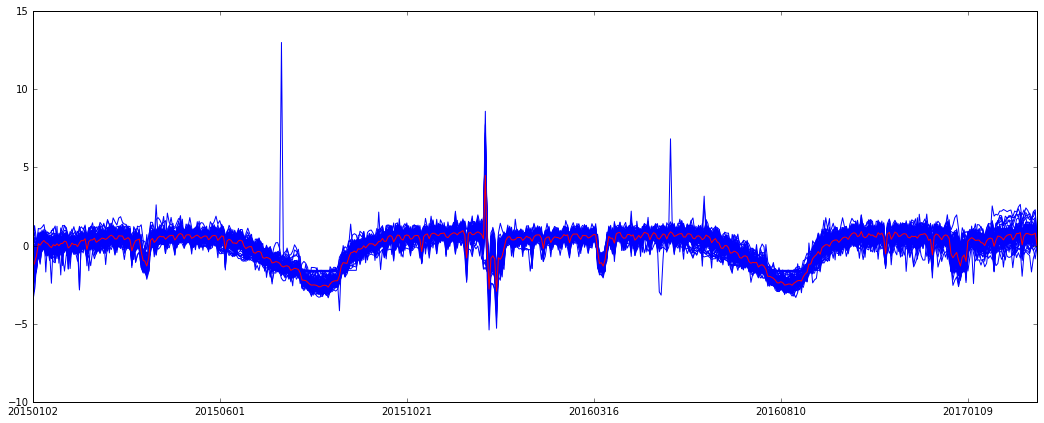

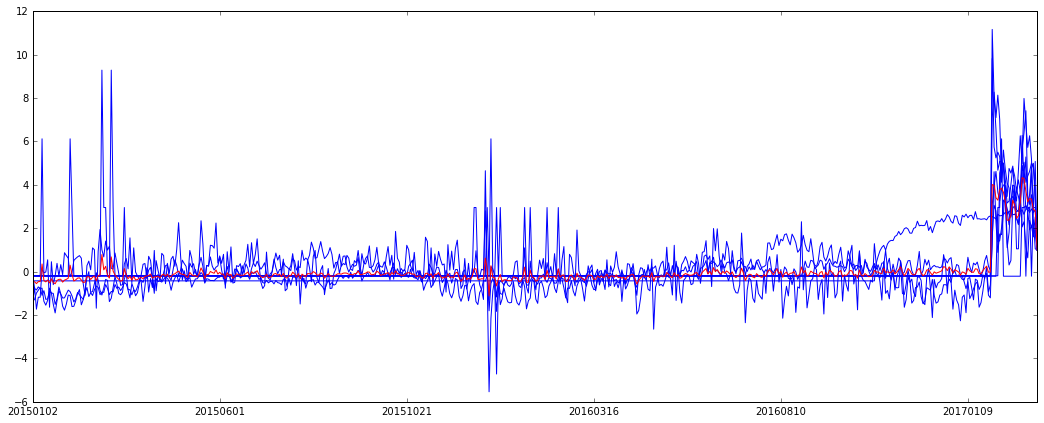

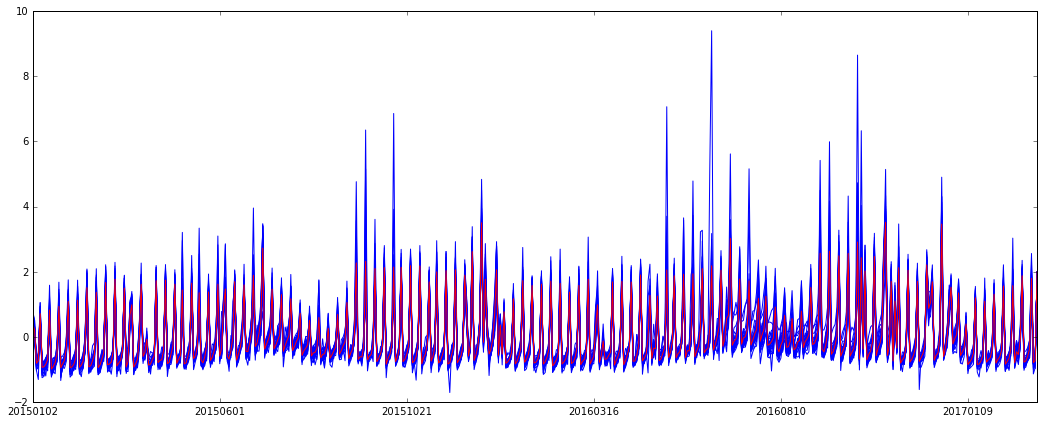

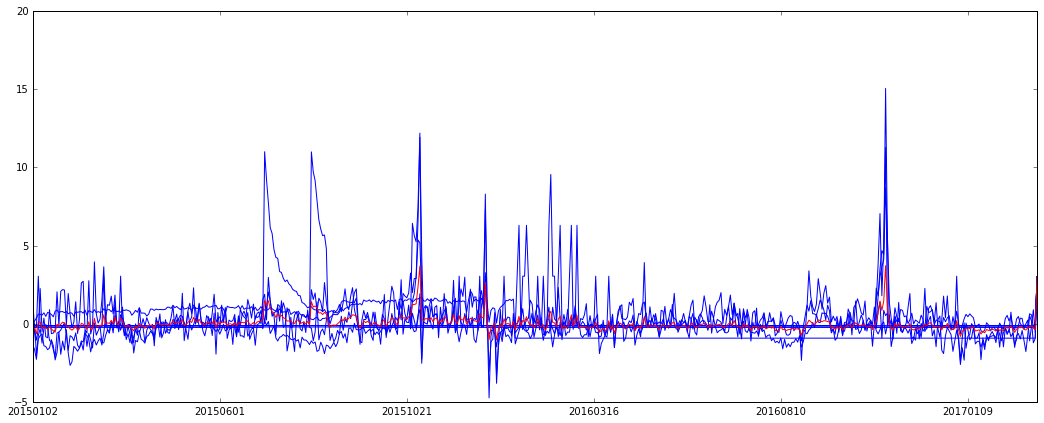

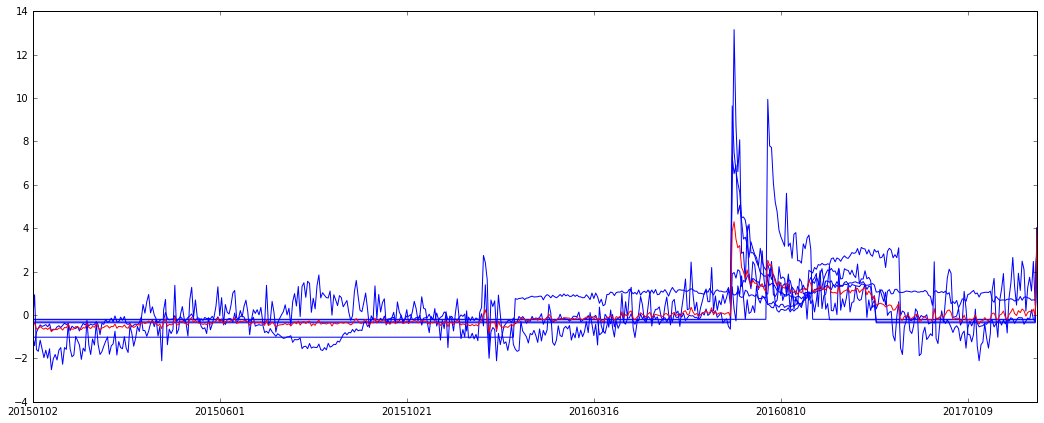

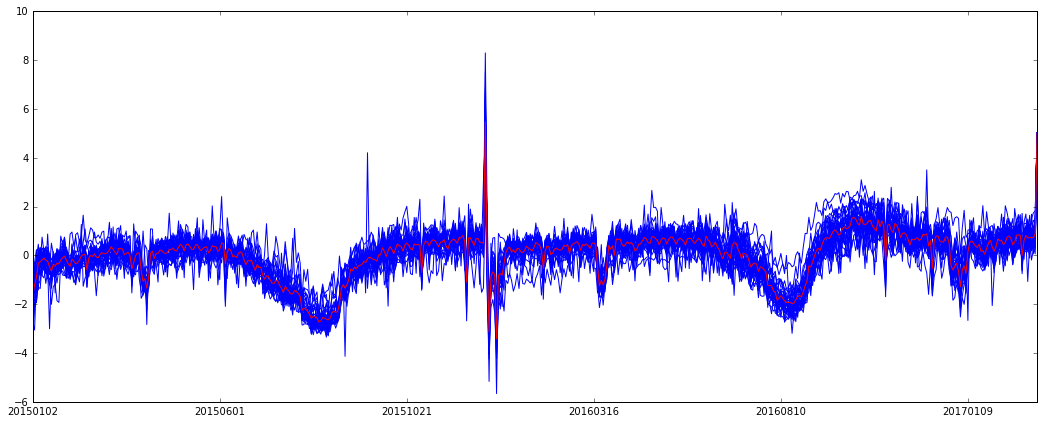

In [22]:
# plot clusterized time series
df_laborables_plot=df_laborables_plot.ix[:,df_laborables_plot.columns != 'linea']
assignations_laborables = df_laborables_plot['cluster']

assignations_laborables_clust = df_centroides_laborables['cluster']


for k in range(6):
    fig,ax = plt.subplots(figsize=(18,7))
    selector = assignations_laborables==k
    selector_clust = assignations_laborables_clust==k


    if selector.any():
        df_laborables_plot[selector].transpose().plot(ax=ax,legend=False, color='blue')
        df_centroides_laborables[selector_clust].transpose().plot(ax=ax,legend=False, color='red')

##### Festivos

In [23]:
df_clust_festivos=pd.DataFrame(columns=["linea", "cluster"])
array_festivos_lineas = []
array_festivos_clusters = []

nclusters_festivos = 6 # number of clusters. 

kmns_festivos = KMeans(n_clusters=nclusters_festivos, random_state = 1)

kmns_festivos.fit(df_clustering_festivos.ix[:, df_clustering_festivos.columns != 'linea'])
ids_clusters_festivos = kmns_festivos.labels_.tolist()


print '*** K-Means ***\n'
for i in range(nclusters_festivos):
    print "Numero de Lineas en cluster %d: %d" % (i, ids_clusters_festivos.count(i))
    
for i in range(nclusters_festivos):
    print "\nLineas por cluster %d:" % i
    inds_festivos = (np.where(np.array(ids_clusters_festivos) == i))[0]
    for j in range(len(inds_festivos)):
        array_festivos_clusters.append(i)
        array_festivos_lineas.append(df_clustering_festivos.iloc[inds_festivos[j]]['linea'])
        print "--- %s" % df_clustering_festivos.iloc[inds_festivos[j]]['linea']

df_clust_festivos['linea'] = array_festivos_lineas
df_clust_festivos['cluster'] = array_festivos_clusters

/mnt/data1/cloudera/parcels/Anaconda-4.0.0/envs/pyspark/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


*** K-Means ***

Numero de Lineas en cluster 0: 27
Numero de Lineas en cluster 1: 118
Numero de Lineas en cluster 2: 10
Numero de Lineas en cluster 3: 41
Numero de Lineas en cluster 4: 4
Numero de Lineas en cluster 5: 8

Lineas por cluster 0:
--- 3.0
--- 10.0
--- 24.0
--- 26.0
--- 33.0
--- 37.0
--- 41.0
--- 47.0
--- 56.0
--- 57.0
--- 59.0
--- 76.0
--- 79.0
--- 86.0
--- 107.0
--- 118.0
--- 119.0
--- 130.0
--- 135.0
--- 142.0
--- 143.0
--- 145.0
--- 148.0
--- 171.0
--- 177.0
--- 372.0
--- 481.0

Lineas por cluster 1:
--- 1.0
--- 2.0
--- 4.0
--- 5.0
--- 6.0
--- 7.0
--- 8.0
--- 9.0
--- 11.0
--- 12.0
--- 14.0
--- 15.0
--- 16.0
--- 17.0
--- 18.0
--- 19.0
--- 20.0
--- 21.0
--- 23.0
--- 25.0
--- 27.0
--- 28.0
--- 29.0
--- 30.0
--- 31.0
--- 32.0
--- 34.0
--- 35.0
--- 36.0
--- 38.0
--- 39.0
--- 40.0
--- 42.0
--- 43.0
--- 44.0
--- 45.0
--- 46.0
--- 48.0
--- 49.0
--- 50.0
--- 51.0
--- 52.0
--- 53.0
--- 54.0
--- 55.0
--- 58.0
--- 60.0
--- 61.0
--- 62.0
--- 63.0
--- 64.0
--- 65.0
--- 66.0
--- 67.0
-

In [24]:
df_centroides_festivos = pd.DataFrame(columns=df_clustering_festivos.columns)
del df_centroides_festivos['linea']
#df_centroides_laborables=df_centroides_laborables.rename(columns = {'linea':'cluster'})

for i in range(0,6):
    df_centroides_festivos.loc[i]=kmns_festivos.cluster_centers_[i]
    
df_centroides_festivos['cluster'] = [0,1,2,3,4,5]

In [25]:
df_festivos_plot = pd.merge(df_clustering_festivos, df_clust_festivos, on='linea')

/mnt/data1/cloudera/parcels/Anaconda-4.0.0/envs/pyspark/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


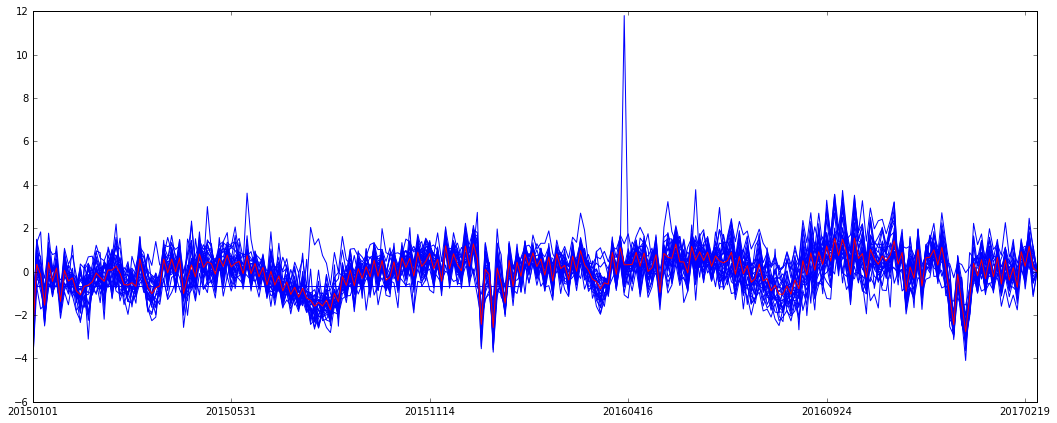

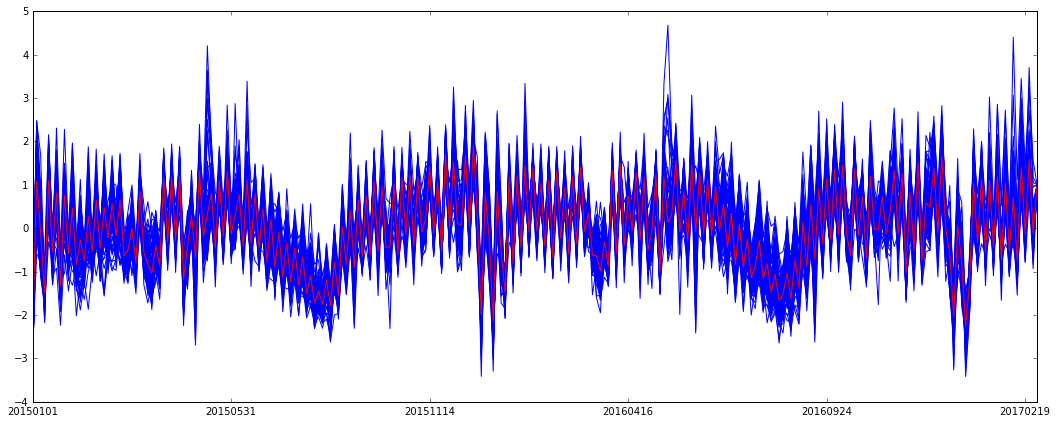

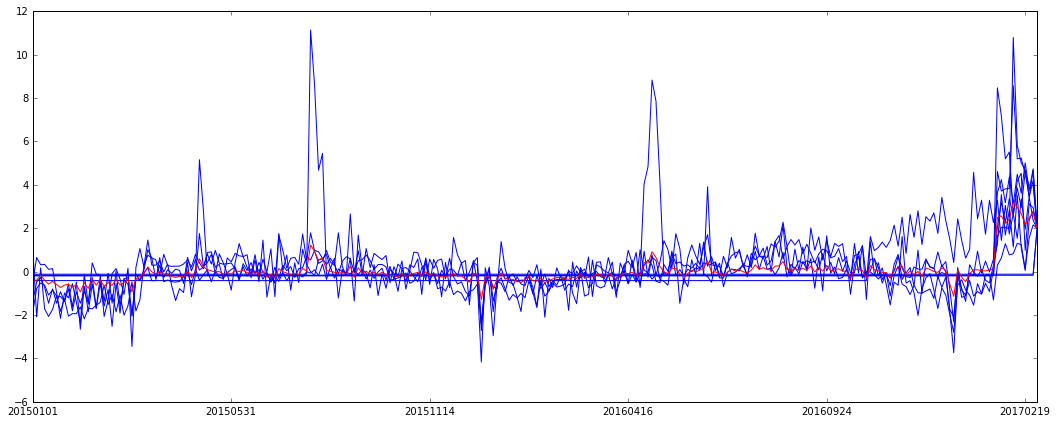

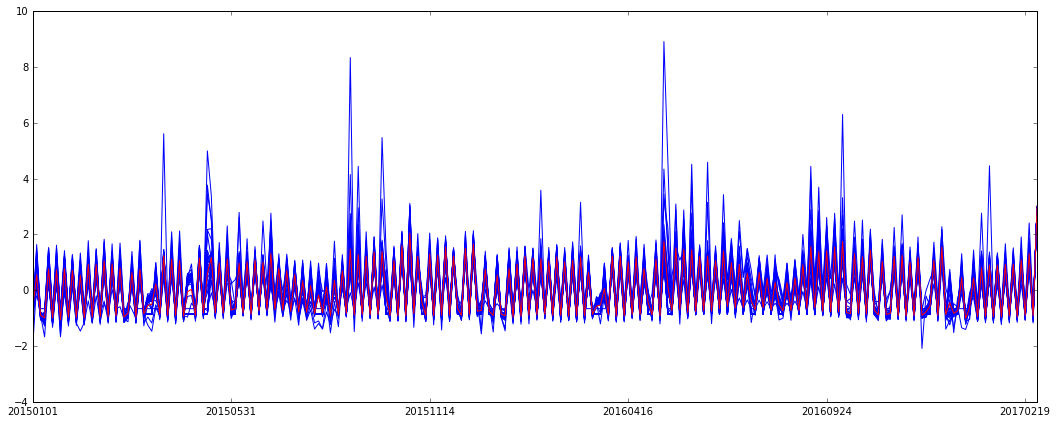

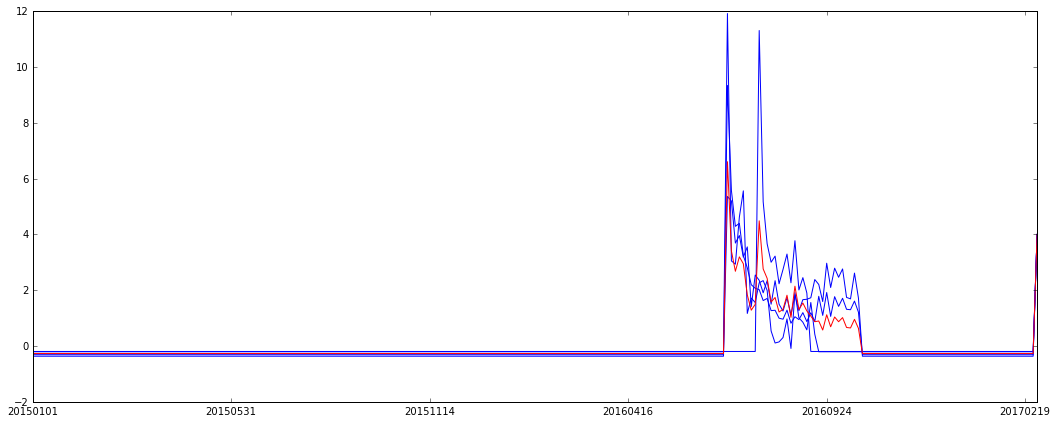

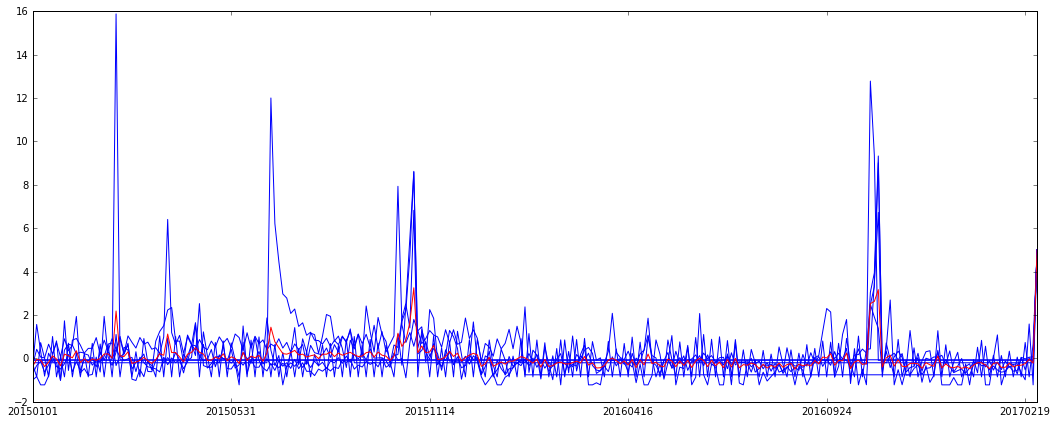

In [26]:
# plot clusterized time series
df_festivos_plot=df_festivos_plot.ix[:,df_festivos_plot.columns != 'linea']
assignations_festivos = df_festivos_plot['cluster']

assignations_festivos_clust = df_centroides_festivos['cluster']


for k in range(6):
    fig,ax = plt.subplots(figsize=(18,7))
    selector = assignations_festivos==k
    selector_clust = assignations_festivos_clust==k


    if selector.any():
        df_festivos_plot[selector].transpose().plot(ax=ax,legend=False, color='blue')
        df_centroides_festivos[selector_clust].transpose().plot(ax=ax,legend=False, color='red')

### 3.2. Plot Correlaciones Clustering

##### Laborables

/opt/cloudera/parcels/Anaconda-4.0.0/envs/pyspark/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


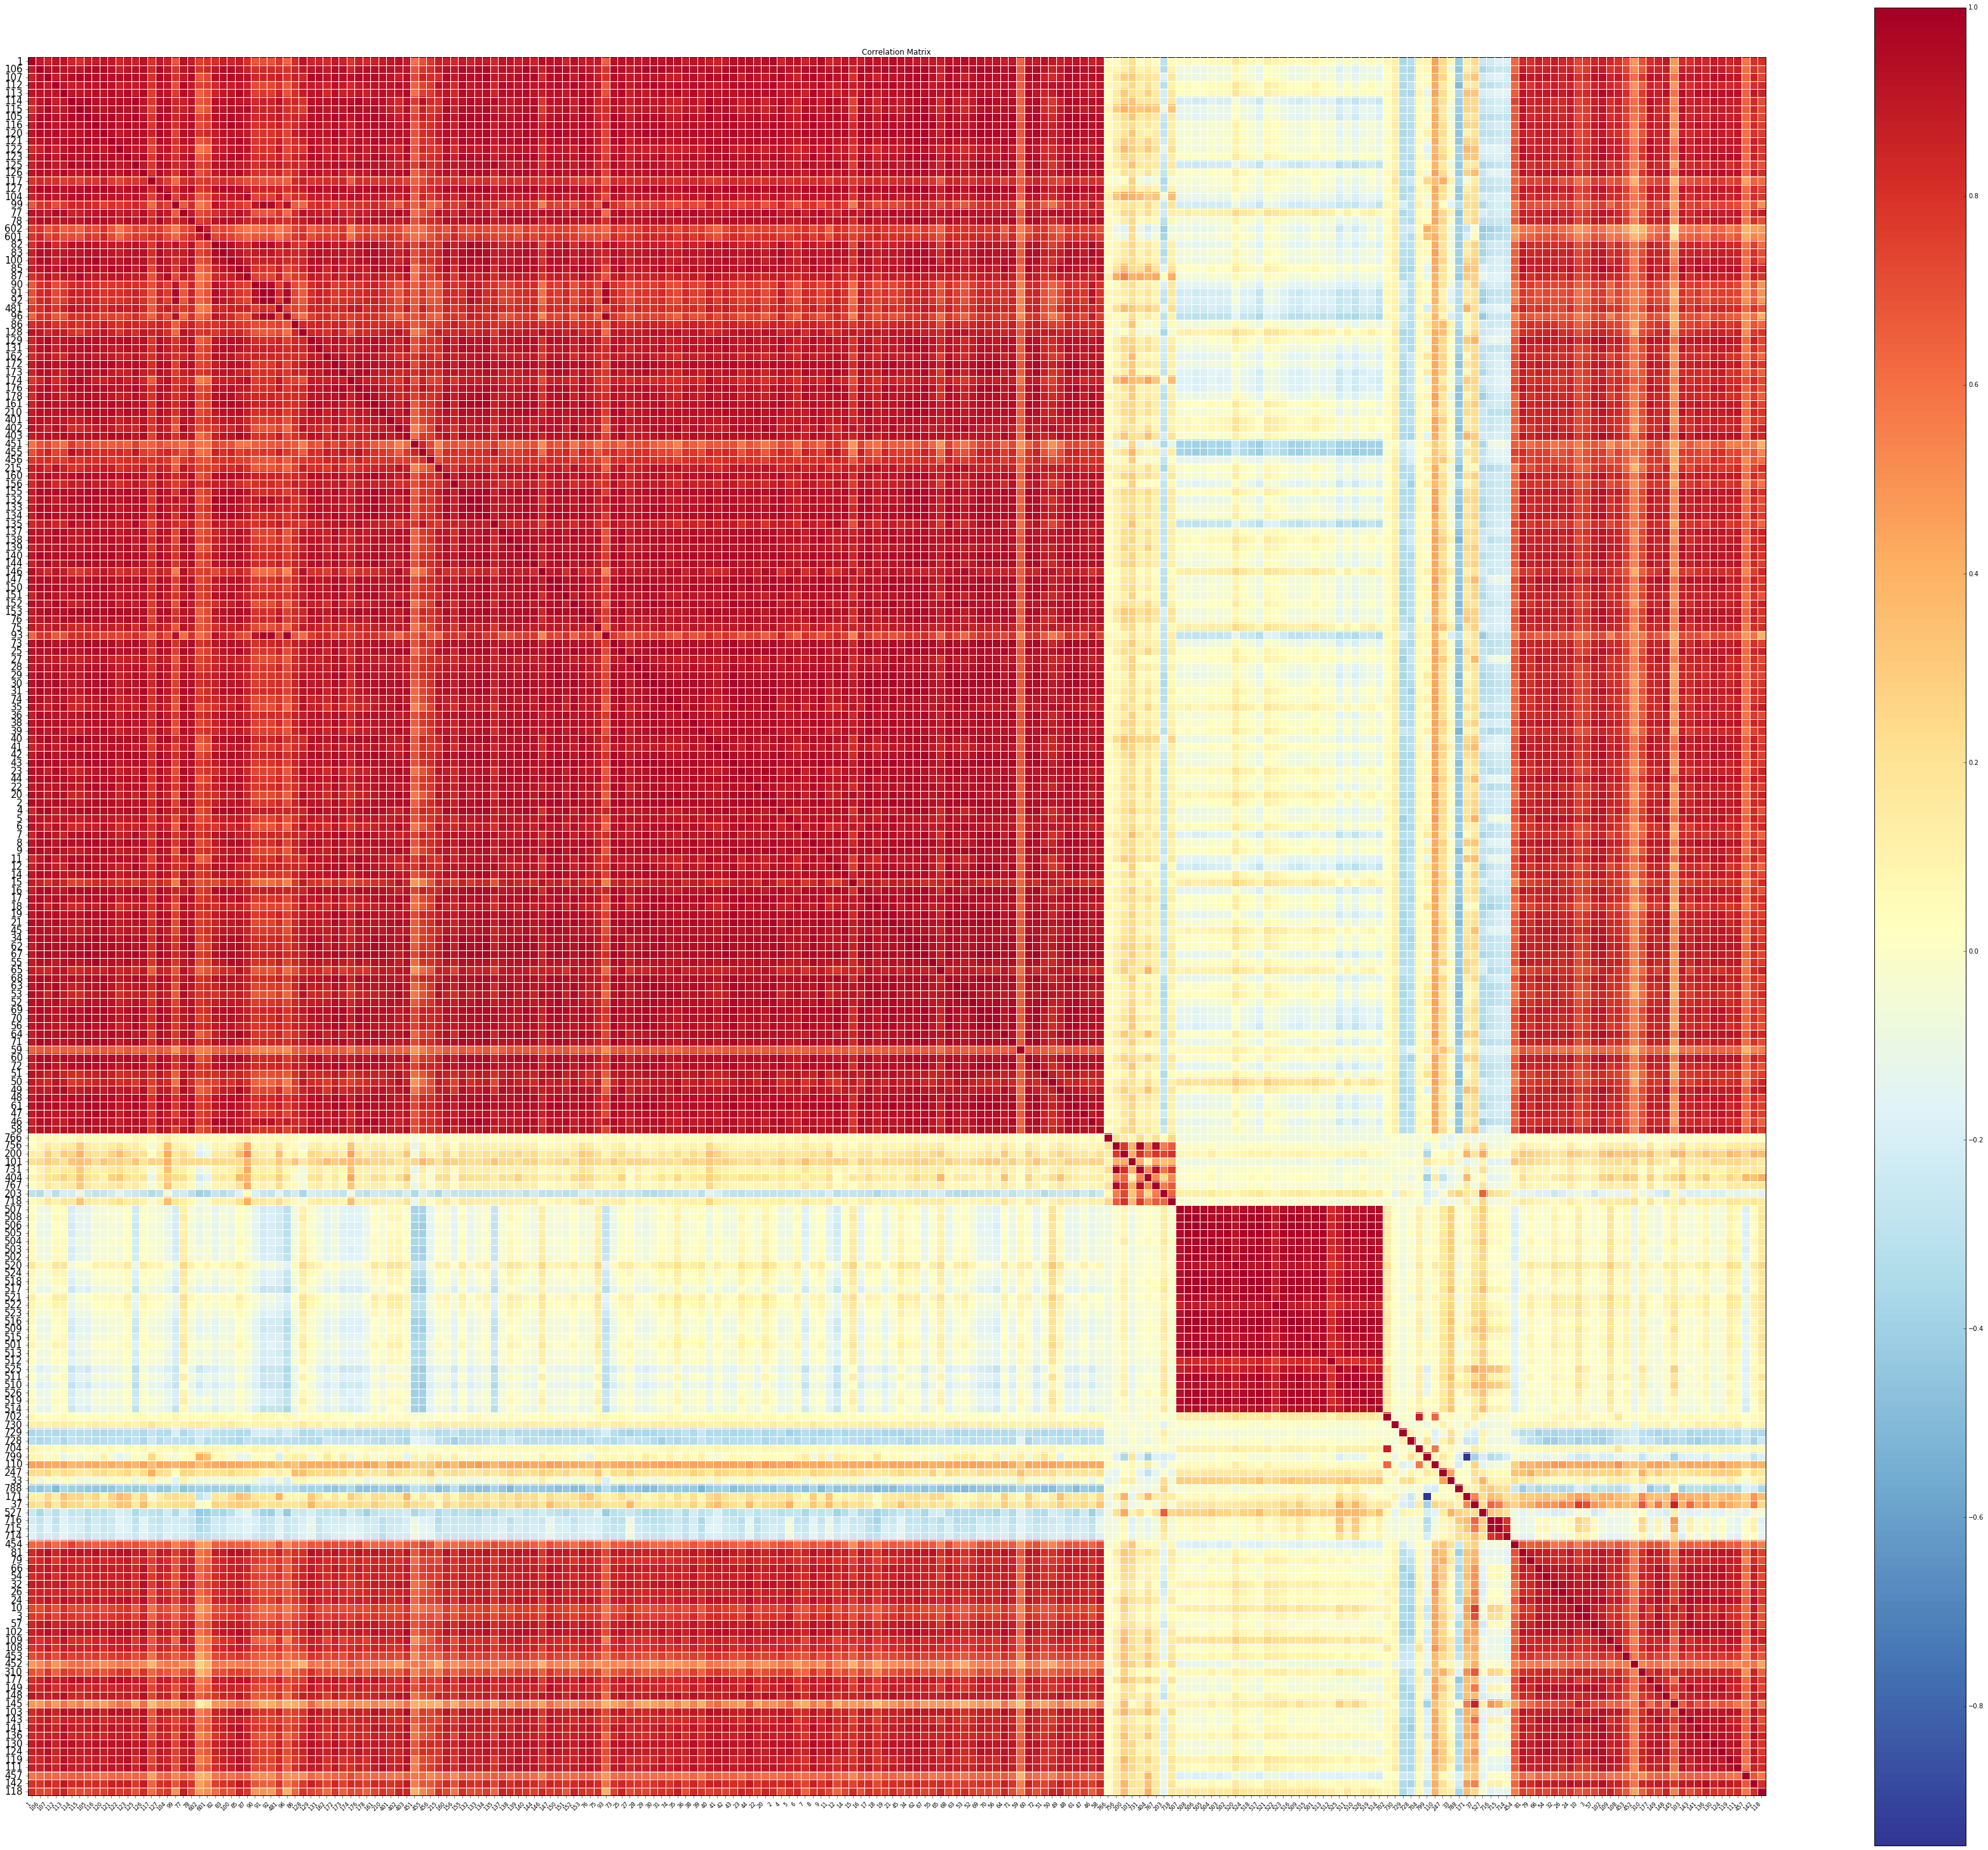

In [27]:
correlations_laborables = np.corrcoef(df_clustering_laborables.ix[:, df_clustering_laborables.columns != 'linea'])

names_laborables=df_clustering_laborables['linea'].tolist()

import statsmodels.api as sm
hie_data_laborables = sm.datasets.randhie.load_pandas()
import copy

# re-arrangement of the correlation matrix according to k-means clustering
inds_laborables = np.argsort(ids_clusters_laborables)

correlations_sorted_laborables = np.zeros((len(inds_laborables),len(inds_laborables)))
names_sorted_laborables = copy.copy(names_laborables)

for i in range(len(inds_laborables)):
    for j in range(len(inds_laborables)):
        correlations_sorted_laborables[i][j] = correlations_laborables[inds_laborables[i]][inds_laborables[j]]
    names_sorted_laborables[i] = names_laborables[inds_laborables[i]]

fig_laborables = sm.graphics.plot_corr(correlations_sorted_laborables, xnames=names_sorted_laborables)
fig_laborables.set_size_inches((50, 50))
plt.yticks(fontsize=15)
plt.show()

##### Festivos

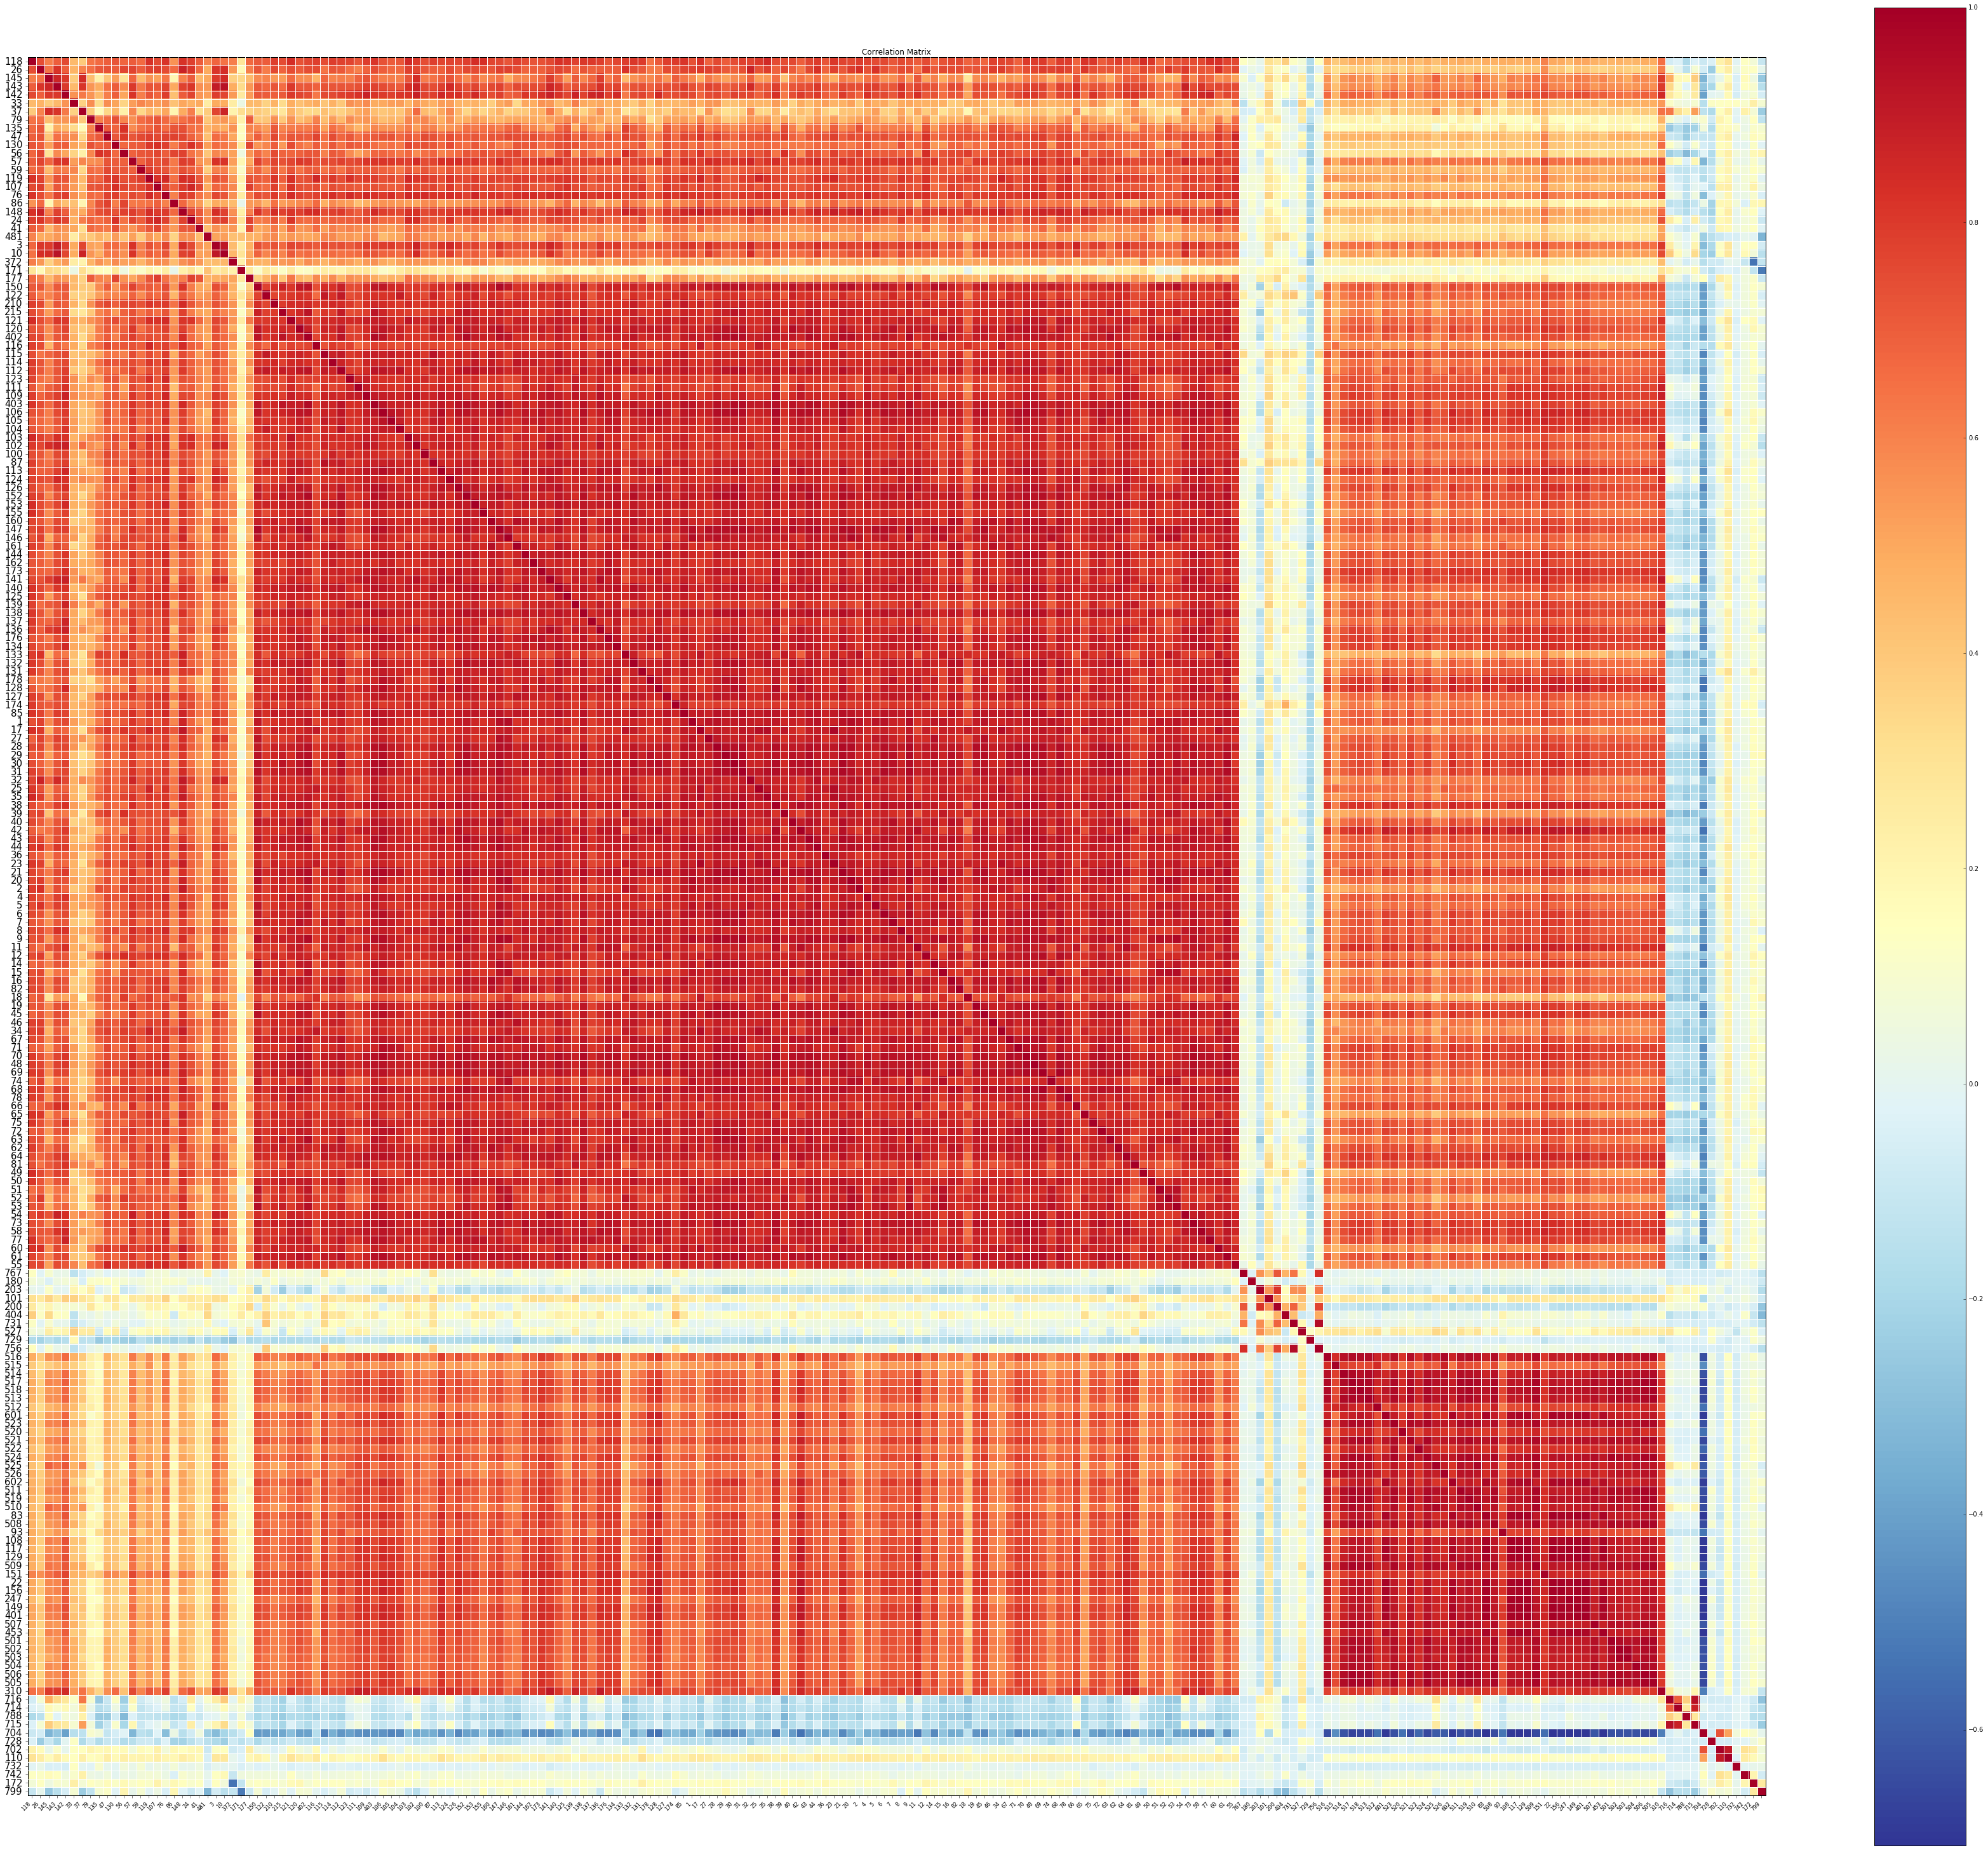

In [28]:
correlations_festivos = np.corrcoef(df_clustering_festivos.ix[:, df_clustering_festivos.columns != 'linea'])

names_festivos=df_clustering_festivos['linea'].tolist()

import statsmodels.api as sm
hie_data_festivos = sm.datasets.randhie.load_pandas()
import copy

# re-arrangement of the correlation matrix according to k-means clustering
inds_festivos = np.argsort(ids_clusters_festivos)

correlations_sorted_festivos = np.zeros((len(inds_festivos),len(inds_festivos)))
names_sorted_festivos = copy.copy(names_festivos)

for i in range(len(inds_festivos)):
    for j in range(len(inds_festivos)):
        correlations_sorted_festivos[i][j] = correlations_festivos[inds_festivos[i]][inds_festivos[j]]
    names_sorted_festivos[i] = names_festivos[inds_festivos[i]]

fig_festivos = sm.graphics.plot_corr(correlations_sorted_festivos, xnames=names_sorted_festivos)
fig_festivos.set_size_inches((50, 50))
plt.yticks(fontsize=15)
plt.show()

### 3.3. Clustering Jerárquico

##### Laborables

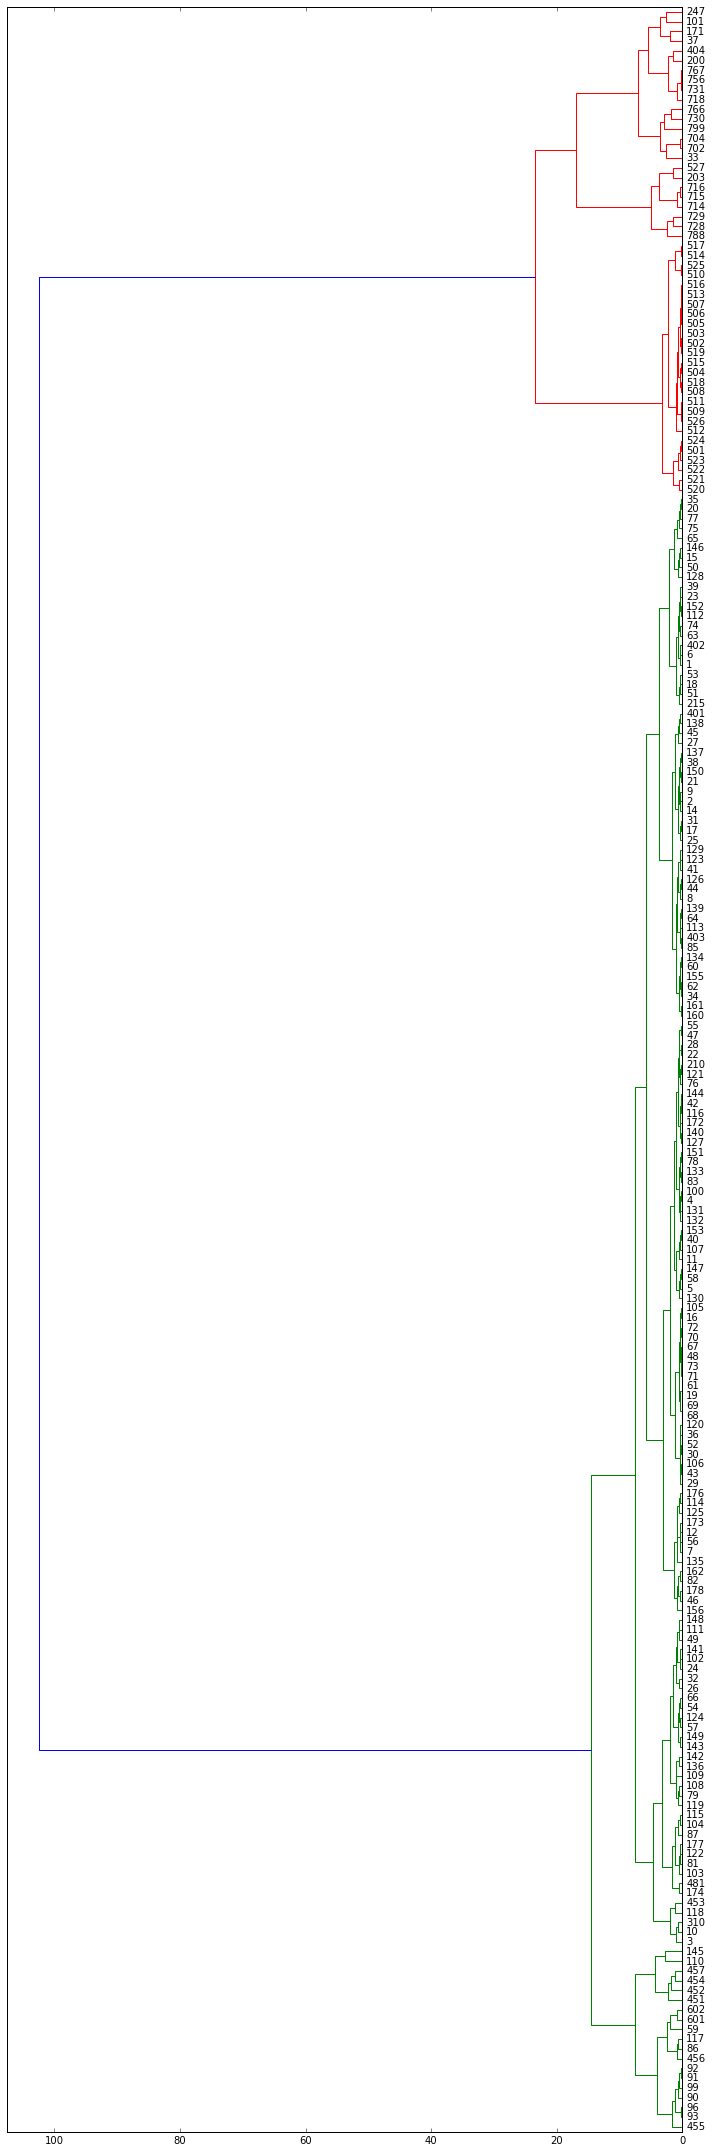

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

dists_laborables = pairwise_distances(df_clustering_laborables.ix[:, df_clustering_laborables.columns != 'linea'], metric='correlation')

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix_laborables = ward(dists_laborables)

fig_laborables, ax_laborables = plt.subplots(figsize=(10,30))
dendr_laborables = dendrogram(linkage_matrix_laborables, orientation="left", labels=df_clustering_laborables['linea'].tolist())

inds_leaves_laborables = dendr_laborables['leaves']

plt.tick_params(\
               axis = 'x',
                which = 'both',
                bottom = 'off',
                top = 'off',
                labelbottom = 'off')
plt.yticks(fontsize=10)
plt.tight_layout()

##### Festivos

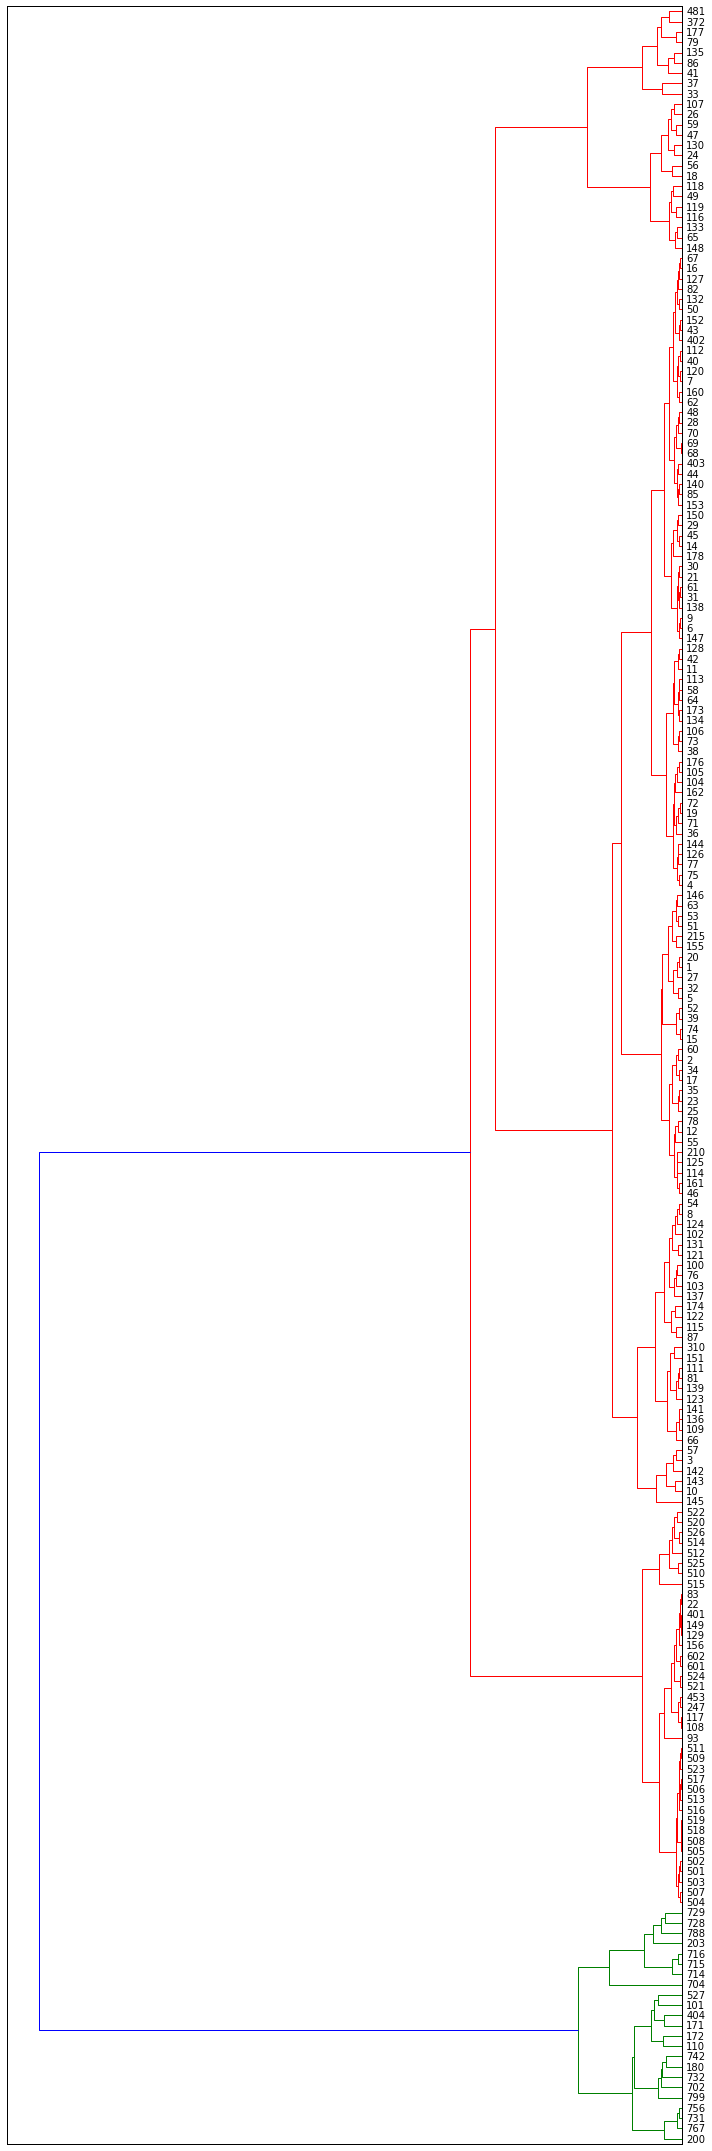

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

dists_festivos = pairwise_distances(df_clustering_festivos.ix[:, df_clustering_festivos.columns != 'linea'], metric='correlation')

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix_festivos = ward(dists_festivos)

fig_festivos, ax_festivos = plt.subplots(figsize=(10,30))
dendr_festivos = dendrogram(linkage_matrix_festivos, orientation="left", labels=df_clustering_festivos['linea'].tolist())

inds_leaves_festivos = dendr_festivos['leaves']

plt.tick_params(\
               axis = 'x',
                which = 'both',
                bottom = 'off',
                top = 'off',
                labelbottom = 'off')
plt.yticks(fontsize=10)
plt.tight_layout()

## 4. Insertar Resultados en Hive

In [31]:
df_clust_laborables = sqlCtx.createDataFrame(df_clust_laborables)
df_clust_festivos = sqlCtx.createDataFrame(df_clust_festivos)

In [32]:
df_clust_laborables.show()
df_clust_festivos.show()

+-----+-------+
|linea|cluster|
+-----+-------+
|  1.0|      0|
|  2.0|      0|
|  4.0|      0|
|  5.0|      0|
|  6.0|      0|
|  7.0|      0|
|  8.0|      0|
|  9.0|      0|
| 11.0|      0|
| 12.0|      0|
| 14.0|      0|
| 15.0|      0|
| 16.0|      0|
| 17.0|      0|
| 18.0|      0|
| 19.0|      0|
| 20.0|      0|
| 21.0|      0|
| 22.0|      0|
| 23.0|      0|
+-----+-------+
only showing top 20 rows

+-----+-------+
|linea|cluster|
+-----+-------+
|  3.0|      0|
| 10.0|      0|
| 24.0|      0|
| 26.0|      0|
| 33.0|      0|
| 37.0|      0|
| 41.0|      0|
| 47.0|      0|
| 56.0|      0|
| 57.0|      0|
| 59.0|      0|
| 76.0|      0|
| 79.0|      0|
| 86.0|      0|
|107.0|      0|
|118.0|      0|
|119.0|      0|
|130.0|      0|
|135.0|      0|
|142.0|      0|
+-----+-------+
only showing top 20 rows



In [33]:
from pyspark.sql import HiveContext
hiveCtx = HiveContext(sc)

In [34]:
df_clust_laborables.write.format("orc").mode("overwrite").saveAsTable("emt_smartbus.clustering1_laborables")
df_clust_festivos.write.format("orc").mode("overwrite").saveAsTable("emt_smartbus.clustering1_festivos")